In [1]:
import os
import platform
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/"
    "pacoty.mplstyle"
)
plt.rcParams["figure.dpi"] = 600
plt.rcParams["axes.xmargin"] = 0.001
plt.rcParams["axes.ymargin"] = 0.01

In [2]:
df = (
    pd.read_csv("./example.csv", names=["data"]).rename_axis("idx").iloc[:2500]
)

In [3]:
def detect_motifs(
    data: pd.Series,
    motif_length: int,
    major_factor: float,
    minor_factor: float,
) -> tuple[pd.DataFrame, float]:
    """
    Detects time series motifs using a modified version of the algorithm from
    "Exact Discovery of Time Series Motifs" by Abdullah Mueen et al.

    ---
    **Reference:**
    http://www.cs.ucr.edu/~eamonn/exact_motif/

    ---
    ### Description
    Identifies recurring patterns (motifs) in a one-dimensional time series
    using an external motif detection binary (`md.exe`).

    The function automatically adjusts execution for Windows, Linux, and macOS:
    - On **Windows**, it runs `md.exe` directly and fixes file permissions if needed.
    - On **Linux/macOS**, it checks for `wine` and guides installation if required.

    ---
    ### Parameters
    - **data** (`pd.Series`):
      One-dimensional input time series.
    - **motif_length** (`int`):
      Length of each motif subsequence.
    - **major_factor** (`float`):
      Major factor of cluster radius (>1 and >minor_factor).
    - **minor_factor** (`float`):
      Minor factor of cluster radius (>1).

    ---
    ### Returns
    - **motifs** (`pd.DataFrame`):
      A DataFrame containing all discovered motifs.
      Each motif is represented as a block of values, organized by:
      - **Group** — motif cluster number
      - **Number** — motif index within the group
      - **Id** — unique identifier for each time point within a motif

      Columns are multi-indexed for hierarchical representation of
      (Group, Number, Id) relationships.

      Example layout:
      ```
      Group | Number | Id | value
      -------|---------|----|-------
      0      | 0       | 0  | 1.23
      0      | 0       | 1  | 1.45
      0      | 1       | 0  | 2.01
      ...
      ```

    - **bsfb** (`float`):
      The final Euclidean distance (best-so-far break) computed by the algorithm.

    ---
    ### Error Handling
    - Automatically fixes permission errors on Windows.
    - On Linux/macOS, prompts to install `wine` if needed to run `md.exe`.
    - Raises descriptive errors for missing executables or failed executions.

    ---
    ### Example
    ```python
    import pandas as pd

    series = pd.Series([1, 2, 3, 2, 1, 2, 3, 2, 1])
    motifs, bsfb = detect_motifs(series, 3, 2.0, 1.5)

    print(motifs.head())
    print("BSFB:", bsfb)
    ```
    """

    # --- Validate Input ---
    if not isinstance(data, pd.Series):
        raise TypeError("Input data must be a pandas Series.")
    if data.ndim != 1:
        raise ValueError("Input series must be one-dimensional.")

    # --- Prepare temporary input file ---
    tmp_file = "tmp.txt"
    data.to_csv(
        tmp_file,
        header=False,
        index=False,
        sep=" ",
        float_format="%.18e",
    )

    series_length = len(data)
    exe_name = "md.exe"

    # --- Determine OS and command ---
    system_name = platform.system().lower()

    if system_name == "windows":
        # Ensure file is executable
        if not os.path.exists(exe_name):
            raise FileNotFoundError(
                f"Could not find '{exe_name}' in the current directory."
            )

        try:
            # Attempt to set permissions (in case of "Permission denied")
            os.chmod(exe_name, 0o755)
        except PermissionError:
            raise PermissionError(
                f"Permission denied when accessing '{exe_name}'. "
                f"Try running Python as administrator or check file permissions."
            )

        cmd = [
            exe_name,
            tmp_file,
            str(series_length),
            str(motif_length),
            str(major_factor),
            str(minor_factor),
            "10",
        ]

    elif system_name in ("linux", "darwin"):  # macOS = darwin
        if not os.path.exists(exe_name):
            raise FileNotFoundError(
                f"'{exe_name}' not found. This file is a Windows executable. "
                f"It cannot run directly on {system_name}."
            )

        # Check if Wine is installed
        try:
            subprocess.run(
                ["wine", "--version"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                check=True,
            )
        except (FileNotFoundError, subprocess.CalledProcessError):
            raise RuntimeError(
                "Wine is required to run md.exe on Linux/macOS.\n"
                "Install it using:\n"
                "  sudo apt install wine  (on Ubuntu/Debian)\n"
                "  brew install wine       (on macOS)\n"
            )

        cmd = [
            "wine",
            exe_name,
            tmp_file,
            str(series_length),
            str(motif_length),
            str(major_factor),
            str(minor_factor),
            "10",
        ]
    else:
        raise RuntimeError(f"Unsupported operating system: {system_name}")

    # --- Execute the command ---
    try:
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            universal_newlines=True,
        )
        stdout_text, stderr_text = process.communicate(input="1\n\n")

        if process.returncode != 0:
            raise RuntimeError(
                f"md.exe execution failed:\n{stderr_text.strip()}"
            )

    finally:
        if os.path.exists(tmp_file):
            os.remove(tmp_file)

    # --- Parse output ---
    values = [v.strip() for v in stdout_text.split(";") if v.strip()]

    motifs = pd.concat(
        [
            pd.concat(
                [
                    data.iloc[
                        int(motif_index) : int(motif_index) + motif_length
                    ]
                    .rename_axis("index")
                    .to_frame("value")
                    .reset_index()
                    .rename_axis("Data", axis=1)
                    .assign(Number=i)
                    .set_index("Number", append=True)
                    .unstack()
                    for i, motif_index in enumerate(motif_group.split(","))
                ],
                axis=1,
            )
            .assign(Group=j)
            .set_index("Group", append=True)
            .unstack()
            .reorder_levels([2, 1, 0], axis=1)  # type: ignore
            for j, motif_group in enumerate(values[:-1])
        ],
        axis=1,
    ).rename_axis("Id")

    bsfb = float(values[-1]) if values else 0.0

    return motifs, bsfb

In [4]:
motifs, bsfb = detect_motifs(df["data"], 25, 4, 2)

motifs

Group      0                                                                \
Number     0                1                2                3              
Data   index      value index      value index      value index      value   
Id                                                                           
0       1711 -7773.9111   464 -7746.6802    58 -7492.5234   393 -7636.5972   
1       1712 -7792.3960   465 -7766.3887    59 -7490.5234   394 -7646.1235   
2       1713 -7799.2192   466 -7772.5674    60 -7488.0806   395 -7655.8574   
3       1714 -7795.6743   467 -7769.3657    61 -7485.0376   396 -7653.8843   
4       1715 -7785.9272   468 -7761.4224    62 -7482.6387   397 -7641.6738   
5       1716 -7772.5103   469 -7752.8896    63 -7479.9199   398 -7636.2051   
6       1717 -7758.5059   470 -7743.3560    64 -7475.7979   399 -7630.6294   
7       1718 -7738.1064   471 -7729.7690    65 -7469.8677   400 -7618.2974   
8       1719 -7714.7153   472 -7712.8970    66 -7462.4482   401 -7598.0483   
9       1720 -7693.6895   473 -7692.2217    67 -7449.7974   402 -7582.9150   
10      1721 -7673.6729   474 -7677.9443    68 -7437.4263   403 -7578.5654   
11      1722 -7648.4248   475 -7664.3506    69 -7427.9585   404 -7571.4722   
12      1723 -7618.4385   476 -7649.7720    70 -7415.5669   405 -7551.1372   
13      1724 -7590.5488   477 -7634.2046    71 -7406.9292   406 -7525.2363   
14      1725 -7566.5552   478 -7614.8833    72 -7400.6875   407 -7519.3872   
15      1726 -7547.7080   479 -7598.5566    73 -7395.9380   408 -7518.6792   
16      1727 -7527.8384   480 -7585.6543    74 -7390.7388   409 -7511.2495   
17      1728 -7504.2715   481 -7573.3071    75 -7385.0107   410 -7497.0723   
18      1729 -7481.1401   482 -7559.3804    76 -7375.6909   411 -7486.4673   
19      1730 -7463.2866   483 -7548.5483    77 -7364.5400   412 -7487.1548   
20      1731 -7453.2905   484 -7540.2261    78 -7357.5967   413 -7486.2622   
21      1732 -7445.4141   485 -7533.1382    79 -7351.2764   414 -7474.0254   
22      1733 -7434.2881   486 -7526.6284    80 -7348.6895   415 -7459.6133   
23      1734 -7427.0430   487 -7522.0776    81 -7351.2344   416 -7456.4224   
24      1735 -7425.9902   488 -7518.5859    82 -7355.6045   417 -7446.2642   

Group                    ...     4                                    \
Number     4             ...     0                1                2   
Data   index      value  ... index      value index      value index   
Id                       ...                                           
0        535 -7580.1323  ...   931 -7484.2515   489 -7515.9595   425   
1        536 -7594.2300  ...   932 -7488.7490   490 -7511.9517   426   
2        537 -7597.1748  ...   933 -7485.2358   491 -7508.4995   427   
3        538 -7593.1372  ...   934 -7474.4404   492 -7502.3208   428   
4        539 -7583.2842  ...   935 -7460.8618   493 -7490.2378   429   
5        540 -7579.7300  ...   936 -7444.9292   494 -7475.3071   430   
6        541 -7572.9282  ...   937 -7428.8003   495 -7460.0913   431   
7        542 -7558.3882  ...   938 -7414.7314   496 -7446.6094   432   
8        543 -7544.7939  ...   939 -7399.1499   497 -7432.1904   433   
9        544 -7537.3774  ...   940 -7384.1006   498 -7416.8667   434   
10       545 -7528.5903  ...   941 -7373.3950   499 -7403.5845   435   
11       546 -7518.6968  ...   942 -7372.4087   500 -7397.2529   436   
12       547 -7506.2031  ...   943 -7371.8164   501 -7398.9541   437   
13       548 -7488.7666  ...   944 -7365.9043   502 -7406.3521   438   
14       549 -7476.0103  ...   945 -7360.2803   503 -7407.2046   439   
15       550 -7465.9688  ...   946 -7365.9883   504 -7405.8931   440   
16       551 -7455.0552  ...   947 -7378.2876   505 -7412.6489   441   
17       552 -7446.0405  ...   948 -7387.6206   506 -7425.1919   442   
18       553 -7437.8735  ...   949 -7389.2007   507 -7434.2939   443   
19       554 -7433.0464  ...   950 -7392.5986   508 -7439.8384   444   
20       

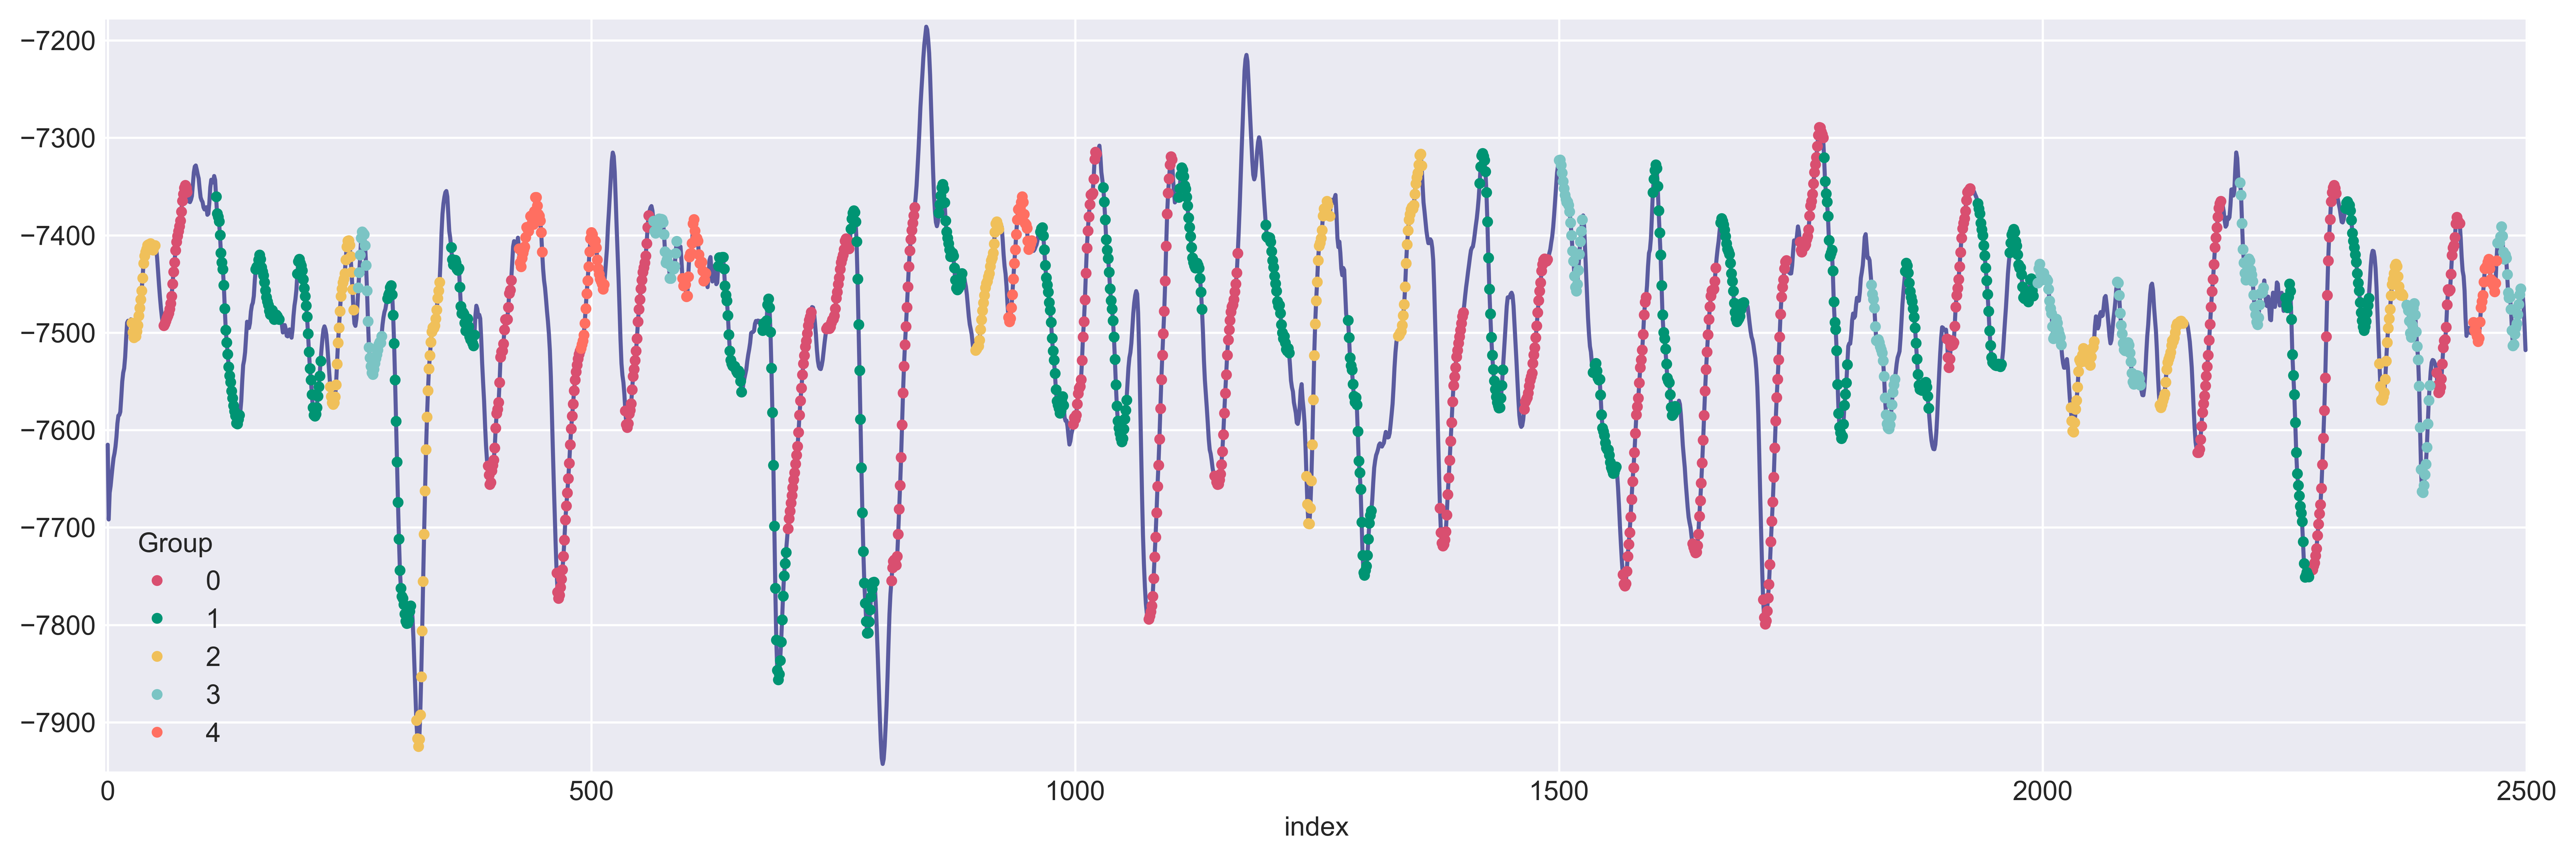

In [5]:
ax = df.plot(figsize=(16, 5), legend=False)

(
    motifs.stack("Number", future_stack=True)
    .stack("Group", future_stack=True)
    .set_index("index", append=True)
    .unstack("Group")
    .droplevel("Data", axis=1)  # type: ignore
    .sort_index(level=["Number", "index"])
    .droplevel(["Id", "Number"])
    .plot(ax=ax, kind="line", linestyle="", marker=".")
);